In [5]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [6]:
datapath = '/mnt/ssd/workspace/stability/MLstability/training_data/'
dset = 'random/'
featurefolder = 'ressummaryfeaturesxgbNorbits10000.0Nout1000/'
features = ['megno']

In [7]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)

In [9]:
IDs = np.array([ 1007,  1021,  1025,  1041, 10518,  1052,  1107,  1120,  1124,
        1128,  1136,  1137,  1138,  1169,  1174,  1190,  1194,  1197,
           1,  1204,  1206, 12073,  1208,  1217,  1223,  1230,  1235,
        1237,  1241,  1248,  1251,  1261,  1266,  1270,  1277, 12840,
        1308,  1313,  1323,  1324,  1337,  1344,  1350,  1356,  1364,
        1366,  1375,  1379,  1396,  1403,  1408,  1412,  1424,  1426,
        1438,  1449,  1476,  1488, 15003,  1504,  1507,  1508,  1513,
        1514, 15220,  1590,  1598,  1601,  1613,  1616,  1617,  1625,
        1627,  1635,  1636,  1640,  1646,  1648,  1657, 16588,  1667,
        1675,  1689,  1691,  1720,  1742,  1753, 17641,  1766,  1768,
        1775,  1785,  1791,  1796,  1799,  1805,  1806,  1810,  1815,
        1819,  1823,  1827,  1829,  1831,  1837,  1838,  1843,  1850,
        1852, 18539, 18651,  1875,  1877,  1879,  1880,  1886,  1899,
        1900,  1911,  1913,  1918, 19197,  1922,  1924,  1928,  1929,
        1942,  1943,  1946,  1954,  1957, 19591,  1971,  1979, 19898,
        1992,  1996,  1999, 20041,  2010,  2018,  2030,  2032,  2048,
        2059, 20620,  2062,  2063,  2066,  2077,  2081,  2083,  2087,
        2094,  2095, 20972,  2103,  2107,  2110,  2113,  2116,  2117,
          21,  2125,  2126,  2135,  2145,  2147,  2159,  2161,  2170,
        2173,  2176,  2179,  2185, 21872,  2190,  2197,  2198,  2203,
        2206,  2214,  2215,    22,  2220,  2222,  2223,  2232,  2233,
        2234,  2241,  2242,  2248,  2256,  2259,  2264,  2274,  2278,
        2285,  2288,  2296,  2299, 22998,  2300, 23005,  2301,  2313,
        2329,  2336,  2340,  2341,  2344,  2359,  2364,  2370,  2372,
        2377,  2383, 23975,  2399, 24008, 24017, 24248, 24346, 24453,
       24576, 24631, 24705, 24763, 24824, 24923, 24930, 24937, 24946,
          25,    28,  3000,    35,  3898,    42,  4753,  5505,  5958,
          62,  7431,  8462,  8744,    91])

In [10]:
trainX.loc[IDs]

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,megno
1007,-587.761726
1021,-7910.165462
1025,-8670.643574
1041,NaN
10518,-8047.659856
1052,-6146.297541
1107,-8711.407313
1120,-7628.118920
1124,-2365.349319
1128,-7277.356470


In [4]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [5]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.8593927800000001                                  
ERROR                                               
0.017368069913021405                                
HOLDOUT SCORE                                       
0.9004524787284618                                  
SCORE:                                                                        
0.9289365                                                                     
ERROR                                                                         
0.003540924690369169                                                          
HOLDOUT SCORE                                                                 
0.9521319471209811                                                            
SCORE:                                                                        
0.94861538                                                                    
ERROR                                             

ERROR                                                                          
0.0032482412398725097                                                          
HOLDOUT SCORE                                                                  
0.9609452799586797                                                             
SCORE:                                                                         
0.93762062                                                                     
ERROR                                                                          
0.0032600303506615325                                                          
HOLDOUT SCORE                                                                  
0.9541867121607266                                                             
SCORE:                                                                         
0.8764915199999999                                                             
ERROR                                   

In [6]:
best

{'x_learning_rate': 0.12617454728850575,
 'x_max_depth': 10,
 'x_min_child': 6.0,
 'x_pos_weight': 4.473177571567236,
 'x_subsample': 0.9103633154465799,
 'x_tree_colsample': 0.501125679315507}

In [7]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.953435+0.00167856	test-auc:0.922465+0.0024765
[1]	train-auc:0.968419+0.00160754	test-auc:0.937259+0.00438004
[2]	train-auc:0.974156+0.00133415	test-auc:0.942675+0.00389297
[3]	train-auc:0.977137+0.00132763	test-auc:0.946266+0.00368639
[4]	train-auc:0.979734+0.00117211	test-auc:0.948063+0.00333505
[5]	train-auc:0.981301+0.000823416	test-auc:0.950103+0.00367516
[6]	train-auc:0.982807+0.000492073	test-auc:0.950868+0.00358185
[7]	train-auc:0.983702+0.000391091	test-auc:0.951886+0.00376636
[8]	train-auc:0.984806+0.000659547	test-auc:0.952888+0.00374195
[9]	train-auc:0.985718+0.000422987	test-auc:0.953628+0.00368378
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.953435       0.001679       0.922465      0.002477
1        0.968419       0.001608       0.937259      0.004380
2        0.974156       0.001334       0.942675      0.003893
3        0.977137       0.001328       0.946266      0.003686
4        0.979734       0.001172       0.948063      0.0

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.9708921202744827


In [8]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.501125679315507, gamma=0,
       learning_rate=0.12617454728850575, max_delta_step=0, max_depth=10,
       min_child_weight=6.0, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=4.473177571567236,
       seed=None, silent=True, subsample=0.9103633154465799)

Text(0.5, 1.0, 'ROC curve (AUC = 0.968)')

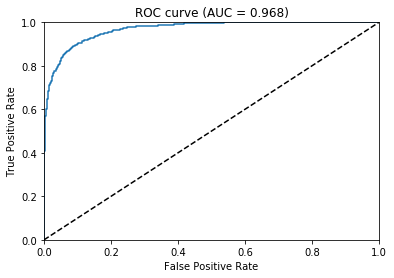

In [9]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [10]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.007183840498328209, recall = 1.0, precision = 0.6698113207547169
Threshold 0.007657343987375498, recall = 0.9993876301285977, precision = 0.6735451919108543
Threshold 0.00865627359598875, recall = 0.9993876301285977, precision = 0.6777408637873754
Threshold 0.009572053328156471, recall = 0.9993876301285977, precision = 0.6819891349770163
Threshold 0.010372571647167206, recall = 0.9993876301285977, precision = 0.6862910008410429
Threshold 0.01166504342108965, recall = 0.9993876301285977, precision = 0.6906474820143885
Threshold 0.012517289258539677, recall = 0.9993876301285977, precision = 0.6950596252129472
Threshold 0.014061043970286846, recall = 0.9993876301285977, precision = 0.6995285040720103
Threshold 0.015737464651465416, recall = 0.9993876301285977, precision = 0.7040552200172563
Threshold 0.016856985166668892, recall = 0.9987752602571953, precision = 0.7082066869300911
Threshold 0.018635522574186325, recall = 0.9975505205143906, precision = 0.7119755244755245
Thres

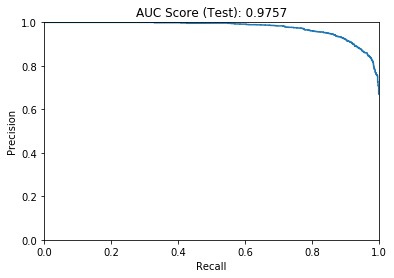

In [11]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 653.4000000000001)

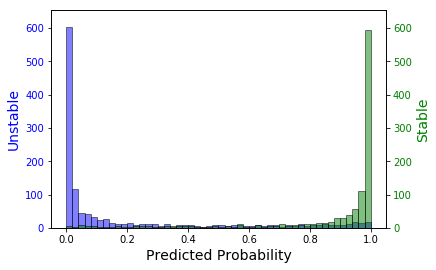

In [12]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,1.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

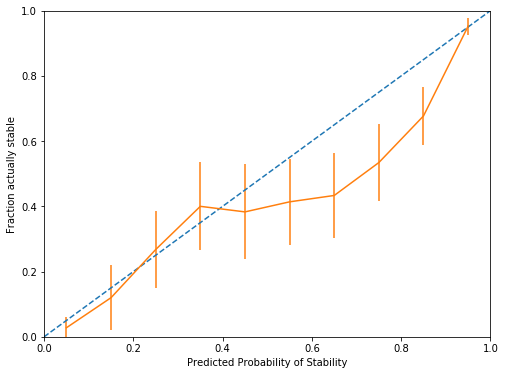

In [13]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

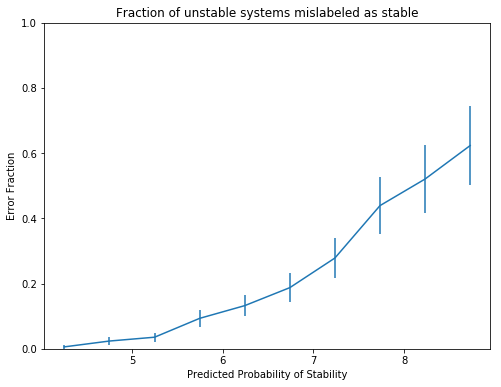

In [7]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

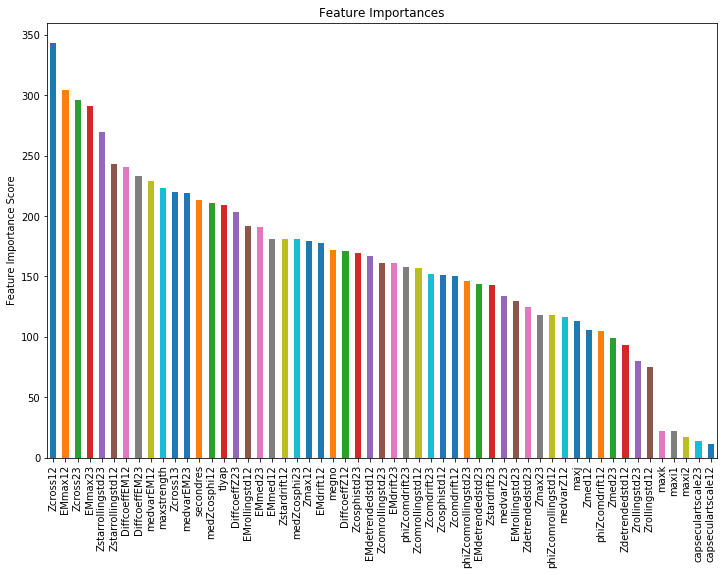

In [14]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [9]:
dill.dump([model, features, featurefolder], open(datapath+"../models/ressummaryfeaturesxgb_random.pkl", "wb"))